# An√°lisis de texto en Python: Bolsa de palabras

* * * 

<div class="alert alert-success"> 

### Objetivos de aprendizaje

* Aprender a convertir datos de texto en n√∫meros mediante el enfoque de Bolsa de palabras.
* Comprender el algoritmo TF-IDF y c√≥mo complementa la representaci√≥n de Bolsa de palabras.
* Implementar Bolsa de palabras y TF-IDF con el paquete `sklearn` y comprender su configuraci√≥n de par√°metros.
* Utilizar las representaciones num√©ricas de datos de texto para realizar an√°lisis de sentimiento.
</div>

### Iconos utilizados en este cuaderno
üîî **Pregunta**: Una pregunta r√°pida para ayudarte a entender qu√© est√° pasando.
ü•ä **Desaf√≠o**: Ejercicios interactivos. ¬°Los trabajaremos en el taller!<br>
üé¨ **Demostraci√≥n**: Mostrando algo m√°s avanzado, ¬°para que sepas para qu√© se puede usar Python!<br>

### Secciones
1. [An√°lisis de datos exploratorios](#section1)
2. [Preprocesamiento](#section2)
3. [La representaci√≥n de la bolsa de palabras](#section3)
4. [Frecuencia de t√©rmino-Frecuencia de documento inversa](#section4)
5. [Clasificaci√≥n de sentimientos mediante la representaci√≥n TF-IDF](#section5)

En la parte anterior, aprendimos a realizar preprocesamiento de texto. Sin embargo, no profundizamos m√°s all√° de los datos textuales. Si nos interesa realizar an√°lisis computacionales de los datos textuales, a√∫n necesitamos enfoques para convertir el texto en una **representaci√≥n num√©rica**.

En la segunda parte de nuestra serie de talleres, exploraremos una de las maneras m√°s sencillas de generar una representaci√≥n num√©rica a partir de texto: la **bolsa de palabras** (BoW). Implementaremos la representaci√≥n BoW para transformar los datos de tuits de aerol√≠neas y luego crearemos un clasificador para explorar qu√© nos dice sobre el sentimiento de los tuits. La base del enfoque de la bolsa de palabras reside en la suposici√≥n de que la frecuencia de tokens espec√≠ficos proporciona informaci√≥n sobre la sem√°ntica y el sentimiento subyacentes al texto.

Para ello, haremos un uso intensivo del paquete `scikit-learn`, ya que proporciona un marco √∫til para construir la representaci√≥n num√©rica.

Primero, instalemos `scikit-learn`.

In [ ]:
# Uncomment to install the package
# %pip install scikit-learn

In [ ]:
# Uncomment to install the NLP packages introduced in Part 1
# %pip install NLTK
# %pip install spaCy
# !python -m spacy download en_core_web_sm

In [1]:
# Import other packages
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
%matplotlib inline

<a id='section1'></a>

# An√°lisis exploratorio de datos

Antes de realizar cualquier preprocesamiento o modelado, siempre debemos realizar un an√°lisis exploratorio de datos para familiarizarnos con ellos.

In [2]:
# Read in data
tweets_path = '../data/airline_tweets.csv'
tweets = pd.read_csv(tweets_path, sep=',')

In [3]:
tweets.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

Como recordatorio, cada fila de este dataframe corresponde a un tuit. Las siguientes columnas son de principal inter√©s. Hay otras columnas que contienen metadatos del tuit, como el autor, la fecha de creaci√≥n, la zona horaria del usuario y otros, que dejaremos de lado por ahora.

- `text` (`str`): el texto del tuit.
- `airline_sentiment` (`str`): el sentimiento del tuit, etiquetado como "neutral", "positivo" o "negativo".
- `airline` (`str`): la aerol√≠nea sobre la que se tuitea.
- `retweet count` (`int`): cu√°ntas veces se retuite√≥ el tuit.

Para prepararnos para la clasificaci√≥n del sentimiento, dividiremos el conjunto de datos para centrarnos en los tuits "positivos" y "negativos" por ahora.

In [4]:
tweets = tweets[tweets['airline_sentiment'] != 'neutral'].reset_index(drop=True)

¬°Primero echemos un vistazo a algunos tweets!

In [5]:
# Print first five tweets
for idx in range(5):
    print(tweets['text'].iloc[idx])

@VirginAmerica plus you've added commercials to the experience... tacky.
@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
@VirginAmerica yes, nearly every time I fly VX this ‚Äúear worm‚Äù won‚Äôt go away :)


Ya podemos ver que algunos de estos tuits contienen sentimientos negativos. ¬øC√≥mo podemos determinarlo?

A continuaci√≥n, analicemos la distribuci√≥n de las etiquetas de sentimiento en este conjunto de datos. 

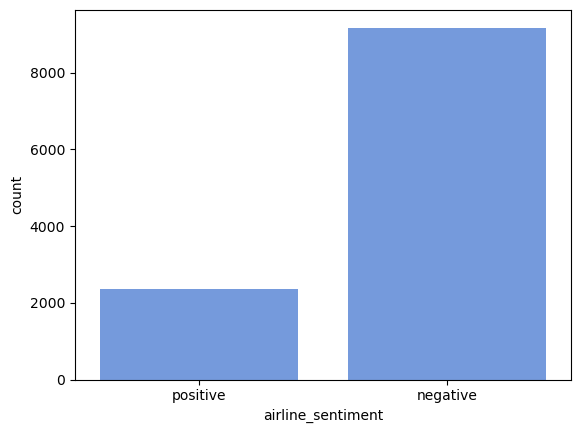

In [6]:
# Make a bar plot showing the count of tweet sentiments
sns.countplot(data=tweets,
              x='airline_sentiment', 
              color='cornflowerblue',
              order=['positive', 'negative']);

Parece que la mayor√≠a de los tuits de este conjunto de datos expresan un sentimiento negativo.

Veamos qu√© se retuitea con m√°s frecuencia:

In [7]:
# Get the mean retweet count for each sentiment
tweets.groupby('airline_sentiment')['retweet_count'].mean()

airline_sentiment
negative    0.093375
positive    0.069403
Name: retweet_count, dtype: float64

¬°Los tuits negativos se retuitean claramente con m√°s frecuencia que los positivos!

Veamos qu√© aerol√≠nea recibe m√°s tuits negativos:

In [8]:
# Get the proportion of negative tweets by airline
proportions = tweets.groupby(['airline', 'airline_sentiment']).size() / tweets.groupby('airline').size()
proportions.unstack().sort_values('negative', ascending=False)

airline_sentiment  negative  positive
airline                              
US Airways         0.893760  0.106240
American           0.853659  0.146341
United             0.842560  0.157440
Southwest          0.675399  0.324601
Delta              0.637091  0.362909
Virgin America     0.543544  0.456456

Parece que la aerol√≠nea m√°s insatisfecha es US Airways, seguida de American Airlines, ¬°ambas con m√°s del 85% de tuits negativos!

Se podr√≠an hacer muchos descubrimientos interesantes si se desea explorar m√°s sobre los datos. Ahora volvamos a nuestro an√°lisis de sentimiento. Antes de eso, necesitamos preprocesar los datos de texto para que est√©n en un formato est√°ndar.

<a id='section2'></a>
# Preprocesamiento

Dedicamos gran parte de la Parte 1 a aprender a preprocesar datos. ¬°Apliquemos lo aprendido! Al observar algunos de los tweets anteriores, podemos ver que, si bien est√°n en buen estado, podemos realizarles procesamiento adicional.

En nuestra canalizaci√≥n, omitiremos el proceso de tokenizaci√≥n, ya que lo realizaremos en un paso posterior. 

## ü•ä Desaf√≠o 1: Aplicar una canalizaci√≥n de limpieza de texto

Escribir una funci√≥n llamada `preprocess` que realice los siguientes pasos en una entrada de texto:

* Paso 1: Convertir el texto en min√∫sculas.
* Paso 2: Reemplazar los siguientes patrones con marcadores de posici√≥n:
* URLs ` URL `
* D√≠gitos ` DIGIT `
* Hashtags ` HASHTAG `
* Usuarios de tweets ` USER `
* Paso 3: Eliminar los espacios en blanco adicionales.

Aqu√≠ tienes algunas sugerencias para guiarte en este desaf√≠o:

* Para el Paso 1, recuerda de la Parte 1 que se puede usar un m√©todo de cadena llamado [`.lower()`](https://docs.python.org/3.11/library/stdtypes.html#str.lower) para convertir texto a min√∫sculas.

* Hemos integrado el Paso 2 en una funci√≥n llamada `placeholder`. Ejecuta la celda a continuaci√≥n para importarla a tu notebook y podr√°s usarla como cualquier otra funci√≥n.

* Para el Paso 3, proporcionamos el patr√≥n de expresiones regulares para identificar espacios en blanco, as√≠ como el reemplazo correcto para extraer espacios en blanco.

Ejecuta la funci√≥n `preprocess` en `example_tweet` (tres celdas a continuaci√≥n) para comprobar si funciona. Si funciona, apl√≠cala a toda la columna `text` del dataframe de tweets.

In [9]:
from utils import placeholder

In [ ]:
blankspace_pattern = r'\s+'
blankspace_repl = ' '

def preprocess(text):
    '''Create a preprocess pipeline that cleans the tweet data.'''
    
    # Step 1: Lowercase
    text = ...

    # Step 2: Replace patterns with placeholders
    text = ...

    # Step 3: Remove extra whitespace characters
    text = ...

    return text

In [11]:
example_tweet = 'lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo'

# Print the example tweet
print(example_tweet)
print(f"{'='*50}")

# Print the preprocessed tweet
print(preprocess(example_tweet))

lol @justinbeiber and @BillGates are like soo 2000 #yesterday #amiright saw it on https://twitter.com #yolo
lol USER and USER are like soo DIGIT HASHTAG HASHTAG saw it on URL HASHTAG


In [12]:
# Apply the function to the text column and assign the preprocessed tweets to a new column
tweets['text_processed'] = tweets['text'].apply(lambda x: preprocess(x))
tweets['text_processed'].head()

0    USER plus you've added commercials to the expe...
1    USER it's really aggressive to blast obnoxious...
2        USER and it's a really big bad thing about it
3    USER seriously would pay $ DIGIT a flight for ...
4    USER yes, nearly every time i fly vx this ‚Äúear...
Name: text_processed, dtype: object

¬°Felicitaciones! El preprocesamiento est√° listo. ¬°Adentr√©monos en el mundo de las palabras!

<a id='section3'></a>
# La Representaci√≥n de la Bolsa de Palabras

La idea de la bolsa de palabras (BdP), como su nombre indica, es bastante intuitiva: tomamos un documento y lo metemos en una bolsa. Esta acci√≥n ignora la posici√≥n relativa entre las palabras, por lo que lo que est√° "en la bolsa" es esencialmente un conjunto de palabras sin clasificar [(Jurafsky y Martin, 2024)](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf). A cambio, obtenemos una lista de palabras √∫nicas y la frecuencia de cada una.

Por ejemplo, como se muestra en la siguiente ilustraci√≥n, la palabra "caf√©" aparece dos veces.

<img src='../images/bow-illustration-1.png' alt="BoW-Part2" width="600">

Con una representaci√≥n de bolsa de palabras, hacemos un uso intensivo de la frecuencia de las palabras, pero no demasiado del orden de las mismas.

En el contexto del an√°lisis de sentimiento, el sentimiento de un tuit se transmite con mayor fuerza mediante palabras espec√≠ficas. Por ejemplo, si un tuit contiene la palabra "feliz", es probable que transmita un sentimiento positivo, pero no siempre (p. ej., "no feliz" denota el sentimiento opuesto). Cuanto m√°s frecuentes sean estas palabras, probablemente transmitan el sentimiento con mayor fuerza.

## Matriz de T√©rminos de Documento

Ahora implementemos la idea de la bolsa de palabras. Antes de profundizar, retrocedamos un momento. En la pr√°ctica, el an√°lisis de texto suele implicar la gesti√≥n de muchos documentos; de ahora en adelante, usaremos el t√©rmino **documento** para representar el fragmento de texto que analizamos. Puede ser una frase, una oraci√≥n, un tuit o cualquier otro texto; siempre que pueda representarse mediante una cadena, la longitud no importa.

Imaginemos que tenemos cuatro documentos (es decir, las cuatro frases mostradas arriba) y los metemos todos en la bolsa. En lugar de una lista de frecuencia de palabras, esperar√≠amos obtener una matriz de t√©rminos de documento (DTM). En una DTM, la lista de palabras es el **vocabulario** (V) que contiene todas las palabras √∫nicas que aparecen en los documentos. Para cada **documento** (D), contamos el n√∫mero de ocurrencias de cada palabra en el vocabulario y luego introducimos el n√∫mero en la matriz. En otras palabras, el DTM que construiremos es una matriz $D \times V$, donde cada fila corresponde a un documento y cada columna corresponde a un token (o "t√©rmino").

Los tokens √∫nicos de este conjunto de documentos, ordenados alfab√©ticamente, forman las columnas. Para cada documento, marcamos la ocurrencia de cada palabra presente en √©l. La representaci√≥n num√©rica de cada documento es una fila en la matriz. Por ejemplo, el primer documento, "el tostador de caf√©", tiene la representaci√≥n num√©rica $[0, 1, 0, 0, 0, 1, 1, 0]$.

Observe que la columna de √≠ndice izquierda ahora muestra estos documentos como texto, pero normalmente solo asignar√≠amos un √≠ndice a cada uno de ellos.

$$
\begin{array}{c|cccccccccccc}
 & \text{americano} & \text{coffee} & \text{iced} & \text{light} & \text{roast} & \text{roaster} & \text{the} & \text{time} \\\hline
\text{the coffee roaster} &0 &1	&0	&0	&0	&1	&1	&0 \\ 
\text{light roast} &0 &0	&0	&1	&1	&0	&0	&0 \\
\text{iced americano} &1 &0	&1	&0	&0	&0	&0	&0 \\
\text{coffee time} &0 &1	&0	&0	&0	&0	&0	&1 \\
\end{array}
$$

Para crear un DTM, utilizaremos `CountVectorizer` del paquete `sklearn`.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

La siguiente ilustraci√≥n muestra el flujo de trabajo de tres pasos para crear un DTM con `CountVectorizr`.

<img src='../images/CountVectorizer1.png' alt="CountVectorizer" width="500">

Repasemos estos pasos con el ejemplo de juguete que se muestra arriba.

### Un ejemplo de juguete

In [14]:
# A toy example containing four documents
test = ['the coffee roaster',
        'light roast',
        'iced americano',
        'coffee time']

El primer paso es inicializar un objeto `CountVectorizer`. Dentro de los par√°grafos circulares, podemos especificar la configuraci√≥n de los par√°metros si lo deseamos. Consultemos la documentaci√≥n (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) para ver las opciones disponibles.

Por ahora, podemos dejarlo en blanco para usar la configuraci√≥n predeterminada.

In [15]:
# Create a CountVectorizer object
vectorizer = CountVectorizer()

El segundo paso es ajustar este objeto `CountVectorizer` a los datos, lo que implica crear un vocabulario de tokens a partir del conjunto de documentos. En tercer lugar, transformamos nuestros datos seg√∫n el objeto `CountVectorizer` ajustado, lo que implica tomar cada documento y contar las ocurrencias de tokens seg√∫n el vocabulario establecido durante el paso de ajuste.

Puede parecer un poco complejo, pero los pasos 2 y 3 se pueden realizar de una sola vez mediante la funci√≥n `fit_transform`.

In [16]:
# Fit and transform to create a DTM
test_count = vectorizer.fit_transform(test)

Se supone que el retorno de `fit_transform` es el DTM.

¬°Ech√©mosle un vistazo!

In [17]:
test_count

<4x8 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

Aparentemente, tenemos una "matriz dispersa", es decir, una matriz con muchos ceros. Esto tiene sentido. En cada documento, hay palabras que no aparecen, y estas se contabilizan como cero en el DTM. Esta matriz dispersa se almacena en formato de "fila dispersa comprimida", un formato que ahorra memoria y est√° dise√±ado para manejar matrices dispersas.

Convirt√°mosla en una matriz densa, donde probablemente esos ceros est√©n representados, como en un array numpy.

In [18]:
# Convert DTM to a dense matrix 
test_count.todense()

matrix([[0, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1]])

¬°As√≠ que este es nuestro DTM! La matriz es la misma que se muestra arriba. Para que sea m√°s legible, la convertiremos en un dataframe. Los nombres de las columnas deben ser tokens en el vocabulario, a los que podemos acceder con la funci√≥n `get_feature_names_out`.

In [19]:
# Retrieve the vocabulary
vectorizer.get_feature_names_out()

array(['americano', 'coffee', 'iced', 'light', 'roast', 'roaster', 'the',
       'time'], dtype=object)

In [20]:
# Create a DTM dataframe
test_dtm = pd.DataFrame(data=test_count.todense(),
                        columns=vectorizer.get_feature_names_out())

¬°Aqu√≠ est√°! El DTM de nuestros datos de juguetes ahora es un marco de datos. El √≠ndice de `test_dtm` corresponde a la posici√≥n de cada documento en la lista `test`.

In [21]:
test_dtm

americano  coffee  iced  light  roast  roaster  the  time
0          0       1     0      0      0        1    1     0
1          0       0     0      1      1        0    0     0
2          1       0     1      0      0        0    0     0
3          0       1     0      0      0        0    0     1

Esperamos que este ejemplo de juguete ofrezca una gu√≠a clara para crear un DTM.

¬°Ahora es el momento de los datos de nuestros tweets!

### DTM para Tweets

Comenzaremos inicializando un objeto `CountVectorizer`. En la siguiente celda, hemos incluido algunos par√°metros que se suelen ajustar. Estos par√°metros est√°n configurados con sus valores predeterminados.

Al construir un DTM, el texto de entrada se escribe en min√∫sculas por defecto. Si no se especifica nada para `stop_words`, se conservan por defecto. Los siguientes tres par√°metros se utilizan para controlar el tama√±o del vocabulario, que abordaremos en breve.

In [22]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True,
                             stop_words=None,
                             min_df=1,
                             max_df=1.0, 
                             max_features=None)

In [23]:
# Fit and transform to create DTM
counts = vectorizer.fit_transform(tweets['text_processed'])
counts

<11541x8751 sparse matrix of type '<class 'numpy.int64'>'
	with 191139 stored elements in Compressed Sparse Row format>

In [24]:
# Do not run if you have limited memory - this includes DataHub and Binder
np.array(counts.todense())

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [25]:
# Extract tokens
tokens = vectorizer.get_feature_names_out()

In [26]:
# Create DTM
first_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)

# Print the shape of DTM
print(first_dtm.shape)

(11541, 8751)


Si dejamos `CountVectorizer` con la configuraci√≥n predeterminada, el tama√±o del vocabulario de los datos del tweet es 8751.

In [27]:
first_dtm.head()

_exact_  _wtvd  aa  aaaand  aadv  aadvantage  aal  aaron  ab  aback  ...  \
0        0      0   0       0     0           0    0      0   0      0  ...   
1        0      0   0       0     0           0    0      0   0      0  ...   
2        0      0   0       0     0           0    0      0   0      0  ...   
3        0      0   0       0     0           0    0      0   0      0  ...   
4        0      0   0       0     0           0    0      0   0      0  ...   

   zero  zig  zip  zippers  zone  zones  zoom  zukes  zurich  zz  
0     0    0    0        0     0      0     0      0       0   0  
1     0    0    0        0     0      0     0      0       0   0  
2     0    0    0        0     0      0     0      0       0   0  
3     0    0    0        0     0      0     0      0       0   0  
4     0    0    0        0     0      0     0      0       0   0  

[5 rows x 8751 columns]

La mayor√≠a de los tokens no aparecen en al menos los primeros cinco tuits.

¬°Echemos un vistazo m√°s de cerca al DTM!

In [28]:
# Most frequent tokens
first_dtm.sum().sort_values(ascending=False).head(10)

user      12882
to         6987
digit      6927
the        5088
you        3635
for        3386
flight     3320
and        3276
on         3142
my         2751
dtype: int64

In [29]:
# Least frequent tokens
first_dtm.sum().sort_values(ascending=True).head(10)

_exact_                     1
mightmismybrosgraduation    1
midterm                     1
midnite                     1
midland                     1
michelle                    1
michele                     1
michael                     1
mhtt                        1
mgmt                        1
dtype: int64

No sorprende que "usuario" y "d√≠gito" se encuentren entre los tokens m√°s frecuentes, ya que reemplazamos cada uno espec√≠fico con estos marcadores. El resto de los tokens m√°s frecuentes son principalmente palabras vac√≠as.

Quiz√°s un patr√≥n m√°s interesante sea buscar qu√© token aparece con m√°s frecuencia en un tuit determinado:

In [30]:
counts = pd.DataFrame()

# Retrieve the index of the tweet where a token appears most frequently
counts['token'] = first_dtm.idxmax(axis=1)

# Retrieve the number of occurrence 
counts['number'] = first_dtm.max(axis=1)

# Filter out placeholders
counts[(counts['token']!='digit')
       & (counts['token']!='hashtag')
       & (counts['token']!='user')].sort_values('number', ascending=False).head(10)

token  number
3127      lt       6
918    worst       6
10572     to       5
8148     the       5
10742     to       5
152       to       5
5005      to       5
10923    the       5
7750      to       5
355       to       5

Parece que, entre todos los tuits, un token aparece como m√°ximo seis veces, y se trata de la palabra "It" o de la palabra "worst".

Regresemos a nuestro marco de datos de tuits y localicemos el tuit n√∫mero 918.

In [31]:
# Retrieve 918th tweet: "worst"
tweets.iloc[918]['text']

"@united is the worst. Worst reservation policies. Worst costumer service. Worst worst worst. Congrats, @Delta you're not that bad!"

## Personalizar el `CountVectorizer`

Hasta ahora, siempre hemos usado la configuraci√≥n de par√°metros predeterminada para crear nuestros DTM, pero en muchos casos, podemos querer personalizar el objeto `CountVectorizer`. El objetivo es filtrar a√∫n m√°s los tokens innecesarios. En el siguiente ejemplo, ajustamos los siguientes par√°metros:

- `stop_words = 'english'`: ignorar las palabras vac√≠as en ingl√©s
- `min_df = 2`: ignorar las palabras que no aparecen al menos dos veces
- `max_df = 0.95`: ignorar las palabras que aparecen en m√°s del 95% de los documentos

üîî **Pregunta**: ¬°Deteng√°monos un momento para analizar si es razonable configurar estos par√°metros! ¬øQu√© opinas?

A menudo, no nos interesan las palabras con frecuencias demasiado bajas o demasiado altas, por lo que usamos `min_df` y `max_df` para filtrarlas. Como alternativa, podemos definir el tama√±o de nuestro vocabulario como $N$ configurando `max_features`. En otras palabras, le indicamos a `CountVectorizer` que solo considere los $N$ tokens m√°s frecuentes al construir el DTM.

In [32]:
# Customize the parameter setting
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [33]:
# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_processed'])
tokens = vectorizer.get_feature_names_out()

# Create the second DTM
second_dtm = pd.DataFrame(data=counts.todense(),
                          index=tweets.index,
                          columns=tokens)

Nuestro segundo DTM tiene un vocabulario sustancialmente m√°s peque√±o en comparaci√≥n con el primero.

In [34]:
print(first_dtm.shape)
print(second_dtm.shape)

(11541, 8751)
(11541, 4471)


In [35]:
second_dtm.head()

aa  aadv  aadvantage  aal  abandoned  abc  ability  able  aboard  abq  ...  \
0   0     0           0    0          0    0        0     0       0    0  ...   
1   0     0           0    0          0    0        0     0       0    0  ...   
2   0     0           0    0          0    0        0     0       0    0  ...   
3   0     0           0    0          0    0        0     0       0    0  ...   
4   0     0           0    0          0    0        0     0       0    0  ...   

   yummy  yup  yvonne  yvr  yyj  yyz  zero  zone  zoom  zurich  
0      0    0       0    0    0    0     0     0     0       0  
1      0    0       0    0    0    0     0     0     0       0  
2      0    0       0    0    0    0     0     0     0       0  
3      0    0       0    0    0    0     0     0     0       0  
4      0    0       0    0    0    0     0     0     0       0  

[5 rows x 4471 columns]

La lista de tokens m√°s frecuentes ahora incluye palabras que tienen m√°s sentido para nosotros, como "cancelado" y "servicio".

In [36]:
second_dtm.sum().sort_values(ascending=False).head(10)

digit        6927
flight       3320
hashtag      2633
cancelled     956
thanks        921
service       910
just          801
customer      726
time          695
help          687
dtype: int64

## ü•ä Desaf√≠o 2: Lematizar la entrada de texto

Recuerde que en la Parte 1 introdujimos el uso de `spaCy` para realizar la lematizaci√≥n, es decir, para recuperar la forma base de una palabra. Este proceso reducir√° el tama√±o del vocabulario al minimizar las variaciones de palabras; un vocabulario m√°s peque√±o puede ayudar a mejorar el rendimiento del modelo en la clasificaci√≥n de sentimientos.

Ahora implementemos la lematizaci√≥n en nuestros datos de tweets y usemos el texto lematizado para crear un tercer DTM.

Complete la funci√≥n `lemmatize_text`. Requiere una entrada de texto y devuelve los lemas de todos los tokens.

Aqu√≠ tienes algunas sugerencias para guiarte en este desaf√≠o:

- Paso 1: Inicializa una lista para almacenar lemas
- Paso 2: Aplica la secuencia `nlp` al texto de entrada
- Paso 3: Itera sobre los tokens en el texto procesado y recupera el lema del token
- PISTA: La lematizaci√≥n es una de las anotaciones ling√º√≠sticas que la secuencia `nlp` realiza autom√°ticamente. Podemos usar `token.lemma_` para acceder a la anotaci√≥n.

In [37]:
# Import spaCy
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
# Create a function to lemmatize text
def lemmatize_text(text):
    '''Lemmatize the text input with spaCy annotations.'''

    # Step 1: Initialize an empty list to hold lemmas
    lemma = ...

    # Step 2: Apply the nlp pipeline to input text
    doc = ...

    # Step 3: Iterate over tokens in the text to get the token lemma
    for token in doc:
        lemma.append(...)

    # Step 4: Join lemmas together into a single string
    text_lemma = ' '.join(lemma)
    
    return text_lemma

¬°Primero apliquemos la funci√≥n al siguiente tweet de ejemplo!

In [39]:
# Apply the function to an example tweet
print(tweets.iloc[33]["text_processed"])
print(f"{'='*50}")
print(lemmatize_text(tweets.iloc[33]['text_processed']))

USER wow this just blew my mind
USER wow this just blow my mind


And then let's lemmatize the tweet data and save the output to a new column  `text_lemmatized`.

In [40]:
# This may take a while!
tweets['text_lemmatized'] = tweets['text_processed'].apply(lambda x: lemmatize_text(x))

Ahora, con la columna `text_lemmatized`, crearemos un tercer DTM. La configuraci√≥n de par√°metros es la misma que la del segundo DTM. 

In [41]:
# Create the vectorizer (the same param setting as previous)
vectorizer = CountVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

# Fit, transform, and get tokens
counts = vectorizer.fit_transform(tweets['text_lemmatized'])
tokens = vectorizer.get_feature_names_out()

# Create the third DTM
third_dtm = pd.DataFrame(data=counts.todense(),
                         index=tweets.index,
                         columns=tokens)
third_dtm.head()

aa  aadv  aadvantage  aal  abandon  abc  ability  able  aboard  abq  ...  \
0   0     0           0    0        0    0        0     0       0    0  ...   
1   0     0           0    0        0    0        0     0       0    0  ...   
2   0     0           0    0        0    0        0     0       0    0  ...   
3   0     0           0    0        0    0        0     0       0    0  ...   
4   0     0           0    0        0    0        0     0       0    0  ...   

   yummy  yup  yvonne  yvr  yyj  yyz  zero  zone  zoom  zurich  
0      0    0       0    0    0    0     0     0     0       0  
1      0    0       0    0    0    0     0     0     0       0  
2      0    0       0    0    0    0     0     0     0       0  
3      0    0       0    0    0    0     0     0     0       0  
4      0    0       0    0    0    0     0     0     0       0  

[5 rows x 3553 columns]

In [42]:
# Print the shapes of three DTMs
print(first_dtm.shape)
print(second_dtm.shape)
print(third_dtm.shape)

(11541, 8751)
(11541, 4471)
(11541, 3553)


Imprimamos los 10 tokens m√°s frecuentes como de costumbre. Estos tokens ahora son lemas y sus conteos tambi√©n cambian despu√©s de la lematizaci√≥n.

In [43]:
# Get the most frequent tokens in the third DTM
third_dtm.sum().sort_values(ascending=False).head(10)

digit       6927
flight      4043
hashtag     2633
thank       1455
hour        1134
cancel       948
delay        937
service      937
customer     902
time         856
dtype: int64

In [44]:
# Compared to the most frequent tokens in the second DTM
second_dtm.sum().sort_values(ascending=False).head(10)

digit        6927
flight       3320
hashtag      2633
cancelled     956
thanks        921
service       910
just          801
customer      726
time          695
help          687
dtype: int64

<a id='section4'></a>

# Frecuencia de T√©rminos - Frecuencia Inversa de Documentos

Hasta ahora, nos basamos en la frecuencia de palabras para obtener informaci√≥n sobre un documento. Esto supone que si una palabra aparece con m√°s frecuencia en un documento, es m√°s informativa. Sin embargo, esto no siempre es as√≠. Por ejemplo, ya hemos eliminado las palabras vac√≠as porque no son informativas, a pesar de aparecer muchas veces en un documento. Tambi√©n sabemos que la palabra "vuelo" es una de las m√°s frecuentes, pero no es tan informativa, ya que aparece en muchos documentos. Dado que estamos analizando tuits de aerol√≠neas, no deber√≠a sorprendernos ver la palabra "vuelo".

Para solucionar esto, utilizamos un esquema de ponderaci√≥n denominado **tf-idf (frecuencia de t√©rmino-frecuencia inversa de documento)**. La idea principal de tf-idf es ponderar una palabra no solo por su frecuencia dentro de un documento, sino tambi√©n por su frecuencia en un documento en relaci√≥n con los dem√°s. Por lo tanto, al construir el DTM, asignamos a cada t√©rmino una **puntuaci√≥n tf-idf**. Espec√≠ficamente, al t√©rmino $t$ del documento $d$ se le asigna una puntuaci√≥n tf-idf de la siguiente manera:

<img src='../images/tf-idf_finalized.png' alt="TF-IDF" width="1200">

En esencia, la puntuaci√≥n tf-idf de una palabra en un documento es el producto de dos componentes: **frecuencia de t√©rmino (tf)** y **frecuencia inversa de documento (idf)**. La idf act√∫a como un factor de escala. Si una palabra aparece en todos los documentos, la idf es igual a 1. No se produce escala. Pero idf suele ser mayor que 1, que es el peso que asignamos a la palabra para aumentar la puntuaci√≥n de tf-idf y destacar su car√°cter informativo. En la pr√°ctica, sumamos 1 tanto al denominador como al numerador ("add-1 smooth") para evitar problemas con cero ocurrencias.

Tambi√©n podemos crear un DTM tf-idf usando `sklearn`. En esta ocasi√≥n, usaremos `TfidfVectorizer`:

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
# Create a tfidf vectorizer
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words='english',
                             min_df=2,
                             max_df=0.95,
                             max_features=None)

In [47]:
# Fit and transform 
tf_dtm = vectorizer.fit_transform(tweets['text_lemmatized'])
tf_dtm

<11541x3553 sparse matrix of type '<class 'numpy.float64'>'
	with 88287 stored elements in Compressed Sparse Row format>

In [48]:
# Create a tf-idf dataframe
tfidf = pd.DataFrame(tf_dtm.todense(),
                     columns=vectorizer.get_feature_names_out(),
                     index=tweets.index)
tfidf.head()

aa  aadv  aadvantage  aal  abandon  abc  ability  able  aboard  abq  ...  \
0  0.0   0.0         0.0  0.0      0.0  0.0      0.0   0.0     0.0  0.0  ...   
1  0.0   0.0         0.0  0.0      0.0  0.0      0.0   0.0     0.0  0.0  ...   
2  0.0   0.0         0.0  0.0      0.0  0.0      0.0   0.0     0.0  0.0  ...   
3  0.0   0.0         0.0  0.0      0.0  0.0      0.0   0.0     0.0  0.0  ...   
4  0.0   0.0         0.0  0.0      0.0  0.0      0.0   0.0     0.0  0.0  ...   

   yummy  yup  yvonne  yvr  yyj  yyz  zero  zone  zoom  zurich  
0    0.0  0.0     0.0  0.0  0.0  0.0   0.0   0.0   0.0     0.0  
1    0.0  0.0     0.0  0.0  0.0  0.0   0.0   0.0   0.0     0.0  
2    0.0  0.0     0.0  0.0  0.0  0.0   0.0   0.0   0.0     0.0  
3    0.0  0.0     0.0  0.0  0.0  0.0   0.0   0.0   0.0     0.0  
4    0.0  0.0     0.0  0.0  0.0  0.0   0.0   0.0   0.0     0.0  

[5 rows x 3553 columns]

Quiz√°s hayas notado que el tama√±o del vocabulario es el mismo que vimos en el Desaf√≠o 2. Esto se debe a que usamos la misma configuraci√≥n de par√°metros al crear el vectorizador. Sin embargo, los valores de la matriz son diferentes: son puntuaciones tf-idf en lugar de conteos brutos.

## Interpretar valores TF-IDF

Analicemos el documento donde un t√©rmino tiene los valores tf-idf m√°s altos. Usaremos el m√©todo `.idxmax()` para encontrar el √≠ndice.

In [49]:
# Retrieve the index of the document
tfidf.idxmax()

aa            10077
aadv           9285
aadvantage     9974
aal           10630
abandon        7859
              ...  
yyz            1350
zero           2705
zone           3177
zoom           3920
zurich        10622
Length: 3553, dtype: int64

Por ejemplo, el t√©rmino "peor" aparece de forma m√°s distintiva en el tuit n√∫mero 918.

In [50]:
tfidf.idxmax()['worst']

918

¬°Recordemos que este es el tweet donde la palabra ‚Äúpeor‚Äù aparece seis veces!

In [51]:
tweets['text_processed'].iloc[918]

"USER is the worst. worst reservation policies. worst costumer service. worst worst worst. congrats, USER you're not that bad!"

¬øQu√© tal "Cancelar"? Veamos otro ejemplo.

In [52]:
tfidf.idxmax()['cancel']

5945

In [53]:
tweets['text_processed'].iloc[5945]

'USER cancelled flighted üò¢'

## ü•ä Desaf√≠o 3: Palabras con las puntuaciones medias m√°s altas en TF-IDF

Hemos obtenido valores de tf-idf para cada t√©rmino en cada documento. Pero ¬øqu√© nos dicen estos valores sobre el sentimiento de los tuits? ¬øHay palabras que sean especialmente informativas para tuits positivos/negativos?

Para explorar esto, recopilemos los √≠ndices de todos los tuits positivos/negativos y calculemos las puntuaciones medias de tf-idf de las palabras que aparecen en cada categor√≠a.

Hemos proporcionado el siguiente c√≥digo de inicio como gu√≠a:
- Cree un subconjunto del marco de datos `tweets` seg√∫n la etiqueta `airline_sentiment` y recupere el √≠ndice de cada subconjunto (`.index`). Asigne el √≠ndice a `positive_index` o `negative_index`. Para cada subconjunto:
- Obtener la representaci√≥n td-idf
- Obtener la media de los valores tf-idf del subconjunto con `.mean()`
- Ordenar la media de los valores en orden descendente con `.sort_values()`
- Obtener los 10 t√©rminos principales con `.head()`

A continuaci√≥n, ejecutar `pos.plot` y `neg.plot` para representar gr√°ficamente las palabras con las puntuaciones medias tf-idf m√°s altas para cada subconjunto.

In [ ]:
# Complete the boolean masks 
positive_index = tweets[...].index
negative_index = tweets[...].index

In [ ]:
# Complete the following two lines
pos = tfidf.loc[...].mean().sort_values(...).head(...)
neg = tfidf.loc[...].mean().sort_values(...).head(...)

In [ ]:
pos.plot(kind='barh', 
         xlim=(0, 0.18),
         color='cornflowerblue',
         title='Top 10 terms with the highest mean tf-idf values for positive tweets');

In [ ]:
neg.plot(kind='barh', 
         xlim=(0, 0.18),
         color='darksalmon',
         title='Top 10 terms with the highest mean tf-idf values for negative tweets');

üîî **Pregunta**: ¬øC√≥mo interpretar√≠as estos resultados? ¬°Comparte tu opini√≥n en el chat!

<a id='section5'></a>

## üé¨ **Demostraci√≥n**: Clasificaci√≥n de Sentimientos con la Representaci√≥n TF-IDF

Ahora que tenemos una representaci√≥n TF-IDF del texto, ¬°estamos listos para realizar el an√°lisis de sentimientos!

En esta demostraci√≥n, utilizaremos un modelo de regresi√≥n log√≠stica para realizar la tarea de clasificaci√≥n. Aqu√≠ explicaremos brevemente c√≥mo funciona la regresi√≥n log√≠stica como uno de los m√©todos de Aprendizaje Autom√°tico Supervisado. Si desea obtener m√°s informaci√≥n, no dude en explorar nuestro taller sobre Fundamentos del Aprendizaje Autom√°tico en Python (https://github.com/dlab-berkeley/Python-Machine-Learning).

La regresi√≥n log√≠stica es un modelo lineal que utilizamos para predecir la etiqueta de un tuit, bas√°ndonos en un conjunto de caracter√≠sticas ($x_1, x_2, x_3, ..., x_i$), como se muestra a continuaci√≥n:

$$
L = \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_T x_T
$$

La lista de caracter√≠sticas que pasaremos al modelo es el vocabulario del DTM. Tambi√©n alimentamos el modelo con una parte de los datos, conocida como el conjunto de entrenamiento, junto con otras especificaciones del modelo, para aprender el coeficiente ($\beta_1, \beta_2, \beta_3, ..., \beta_i$) de cada caracter√≠stica. Los coeficientes nos indican si una caracter√≠stica contribuye positiva o negativamente al valor predicho. El valor predicho corresponde a la suma de todas las caracter√≠sticas (multiplicado por sus coeficientes), y se pasa a una funci√≥n sigmoidea para su conversi√≥n al espacio de probabilidad, que nos indica si la etiqueta predicha es positiva (cuando $p>0.5$) o negativa (cuando $p<0.5$).

La parte restante de los datos, conocida como el conjunto de prueba, se utiliza para comprobar si los coeficientes aprendidos pueden generalizarse a datos no analizados.

Ahora que ya tenemos el dataframe tf-idf, el conjunto de caracter√≠sticas est√° listo. ¬°Profundicemos en la especificaci√≥n del modelo!

In [55]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

Usaremos la funci√≥n `train_test_split` de `sklearn` para separar nuestros datos en dos conjuntos:

In [56]:
# Train-test split
X = tfidf
y = tweets['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

La funci√≥n `fit_logistic_regression` se escribe a continuaci√≥n para optimizar el proceso de entrenamiento.

In [57]:
def fit_logistic_regression(X, y):
    '''Fits a logistic regression model to provided data.'''
    model = LogisticRegressionCV(Cs=10,
                                 penalty='l1',
                                 cv=5,
                                 solver='liblinear',
                                 class_weight='balanced',
                                 random_state=42,
                                 refit=True).fit(X, y)
    return model

Ajustaremos el modelo y calcularemos la precisi√≥n del entrenamiento y la prueba.

In [58]:
# Fit the logistic regression model
model = fit_logistic_regression(X_train, y_train)

In [59]:
# Get the training and test accuracy
print(f"Training accuracy: {model.score(X_train, y_train)}")
print(f"Test accuracy: {model.score(X_test, y_test)}")

Training accuracy: 0.9455601998164951
Test accuracy: 0.894919168591224


El modelo alcanz√≥ una precisi√≥n de aproximadamente el 94 % en el conjunto de entrenamiento y del 89 % en el conjunto de prueba, ¬°bastante buena! El modelo se generaliza razonablemente bien a los datos de prueba.

A continuaci√≥n, revisemos tambi√©n los coeficientes ajustados para comprobar si lo que vemos tiene sentido.

Podemos acceder a ellos mediante `coef_` y asociar cada coeficiente con los tokens del vectorizador:

In [60]:
# Get coefs of all features
coefs = model.coef_.ravel()

# Get all tokens
tokens = vectorizer.get_feature_names_out()

# Create a token-coef dataframe
importance = pd.DataFrame()
importance['token'] = tokens
importance['coefs'] = coefs

In [61]:
# Get the top 10 tokens with lowest coefs
neg_coef = importance.sort_values('coefs').head(10)
neg_coef

token      coefs
2724     rude -11.138668
2784    screw  -9.962456
2727     ruin  -9.849836
1505     hour  -9.282416
389     break  -7.949487
2280      pay  -7.823908
458    cancel  -7.534084
264       bad  -7.357206
1872  luggage  -7.093317
3034   strand  -7.046890

In [62]:
# Get the top 10 tokens with highest coefs
pos_coef = importance.sort_values('coefs').tail(10)
pos_coef 

token      coefs
3165     thankful   8.002975
1091  exceptional   8.136278
1563    impressed   8.501364
648    compliment   8.981360
1373        great   9.080558
3498    wonderful   9.401606
1089    excellent  10.147230
250       awesome  10.315909
1746         kudo  11.623828
3164        thank  16.027534

Grafiquemos los 10 tokens principales con los coeficientes m√°s altos/m√°s bajos.

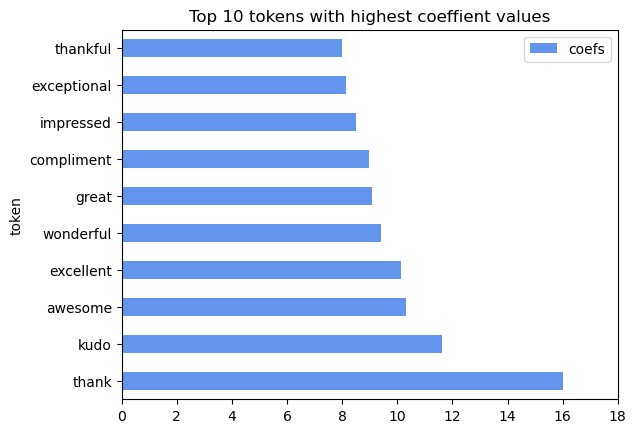

In [63]:
# Plot the top 10 tokens that have the highest coefs
pos_coef.sort_values('coefs', ascending=False) \
        .plot(kind='barh', 
              xlim=(0, 18),
              x='token',
              color='cornflowerblue',
              title='Top 10 tokens with highest coeffient values');

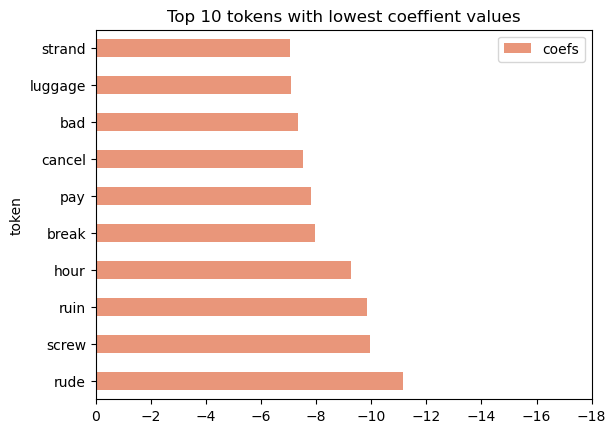

In [64]:
# Plot the top 10 tokens that have the lowest coefs
neg_coef.plot(kind='barh', 
              xlim=(0, -18),
              x='token',
              color='darksalmon',
              title='Top 10 tokens with lowest coeffient values');

Palabras como "ruina", "grosero" y "hora" son fuertes indicadores de sentimiento negativo, mientras que "gracias", "genial" y "maravilloso" se asocian con sentimiento positivo.

Concluiremos la Parte 2 con estos gr√°ficos. Estos t√©rminos de coeficiente y las palabras con los valores TF-IDF m√°s altos ofrecen diferentes perspectivas sobre el sentimiento de los tuits. Si lo desea, t√≥mese un tiempo para comparar los dos conjuntos de gr√°ficos y ver cu√°l refleja mejor los sentimientos transmitidos en los tuits.

<div class="alert alert-success">

## ‚ùóPuntos clave

* Una representaci√≥n de bolsa de palabras es un m√©todo sencillo para transformar nuestros datos de texto en n√∫meros. Se centra en la frecuencia de las palabras, pero no en el orden de las mismas.
* Una representaci√≥n TF-IDF va un paso m√°s all√°; tambi√©n considera si una palabra aparece de forma distintiva en un documento o si aparece de forma uniforme en todos los documentos.
* Con una representaci√≥n num√©rica, podemos realizar diversas tareas de clasificaci√≥n de texto, como el an√°lisis de sentimientos.
</div>